# Data Wrangling and Cleaning
This notebook investigates the raw and partially processed datasets. 

# Orders Dataset

## Cleaning

Cleaning steps are refactored into "belly_rubb_analysis/dataset.py". These include:
    - Enforcing correct datatypes found in "docs/datatypes/".
    - Dropping columns with more than 70% missing values.
    - Dropping duplicate rows.
    - Dropping columns with a constant value.

In [30]:
import os
import pandas as pd

# Data Visualization
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import missingno as msno

# Configuration info
%load_ext autoreload
%autoreload 1
%aimport belly_rubb_analysis.config
from belly_rubb_analysis.config import INTERIM_DATA_DIR, RAW_DATA_DIR, PROFILE_REPORTS_DIR, FIGURES_DIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
orders_df = pd.read_csv(RAW_DATA_DIR / 'orders.csv')

orders_processed_df = pd.read_csv(INTERIM_DATA_DIR / 'orders_processed.csv')

In [3]:
# Generate initial report of orders.csv

if not os.path.exists(PROFILE_REPORTS_DIR / 'orders-profile-report.html'):
    profile = ProfileReport(orders_df, title='Orders Profiling Report')
    profile.to_file('./../reports/profile-reports/orders-profile-report.html')

In [4]:
orders_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Order                     1398 non-null   object 
 1   Order Date                1399 non-null   object 
 2   Order Subtotal            1399 non-null   float64
 3   Order Tax Total           1399 non-null   float64
 4   Order Total               1399 non-null   float64
 5   Fulfillment Date          1399 non-null   object 
 6   Fulfillment Type          1399 non-null   object 
 7   Channels                  1399 non-null   object 
 8   Recipient Name            1399 non-null   object 
 9   Recipient Email           1065 non-null   object 
 10  Recipient Phone           1399 non-null   object 
 11  Item Quantity             1399 non-null   int64  
 12  Item Name                 1398 non-null   object 
 13  Item Variation            1398 non-null   object 
 14  Item Mod

## Missing Values

Although columns with more than 70% missing values were dropped, there are a few left with considerable missingness. These include:

    - `Recipient Email`: 23.8% missing
    - `Order`: 0.1% missing
    - `Item Name`: 0.1% missing
    - `Item Variation`: 0.1% missing
    - `Item Modifiers`: 40.5% missing

These will be investigated for any patterns.

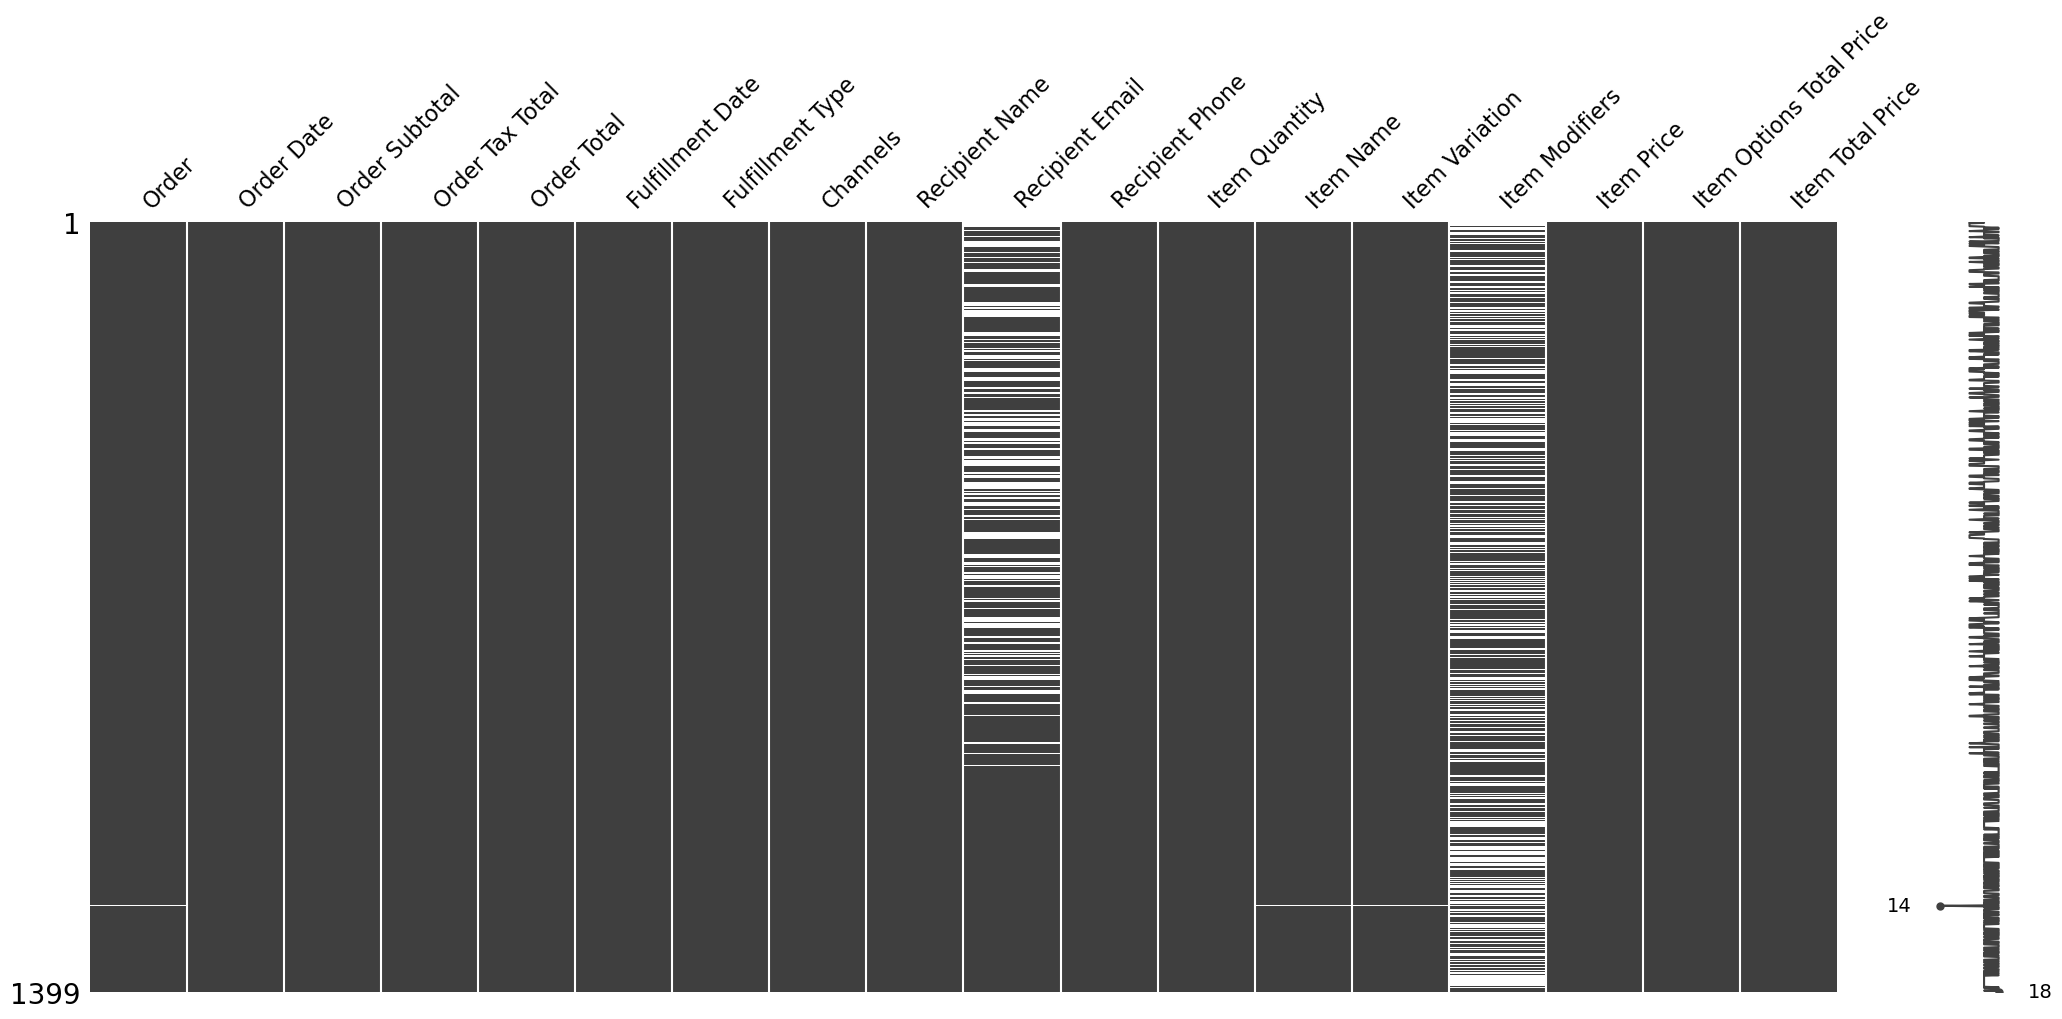

In [5]:
# Visualize missingness matrix

msno.matrix(orders_processed_df)

plt.show()

### Order, Item Name, and Item Variation

There is one row which has missing values between Order, Item Name, Item Variation, and possibly Item Modifiers. We will investigate this row to understand the cause.

In [6]:
# Pull up single row with a missing value in Order

orders_processed_df[orders_processed_df['Order'].isna()]

,Order,Order Date,Order Subtotal,Order Tax Total,Order Total,Fulfillment Date,Fulfillment Type,Channels,Recipient Name,Recipient Email,Recipient Phone,Item Quantity,Item Name,Item Variation,Item Modifiers,Item Price,Item Options Total Price,Item Total Price
1241,NaN,2024-03-07,450.0,42.75,512.75,2024-03-07 16:14:00,Other,Belly Rubb,Levon Safaryan,bidium@gmail.com,+1 818-822-5060,1,NaN,NaN,NaN,450.0,450.0,492.75


Looks like this row is missing information about the items ordered as well. This could have been an order for a family member or friend, catering event, or cash which was entered into the system later.

### Item Modifiers

This column is missing 40.5% of its values. This is most likely due to the fact that this is an optional field for customers to enter personalized modifications when ordering. Just to be sure we'll see if there's a pattern to this missingness.

In [7]:
# Investigate values in Item Modifiers

orders_processed_df['Item Modifiers'].unique()

array([nan, '1 x Signature BBQ Sauce Drizzle, 1 x Salt and Pepper',
       '1 x Lemon Pepper',
       '1 x Sprite ™, 1 x Mac & Cheese, 1 x Rosemary Pepper Fries, 1 x Sweet&Spicy Glaze, 1 x Boom-Boom Sauce DIp',
       '1 x Boom-Boom Sauce DIp, 1 x Sweet and Spicy BBQ Sauce Dip',
       '1 x Sweet and Spicy BBQ Sauce Dip, 1 x Pickled Jalapeño Peppers',
       '1 x Signature BBQ Glaze, 1 x Signature BBQ Sauce Dip',
       '1 x Rosemary Pepper',
       '1 x Salt&Pepper, 1 x Sweet&Spicy glaze (Pairs well w/ LemonPeeper seasoning), 1 x Lemon Pepper, 1 x Signature BBQ Glaze, 1 x Sweet & Spicy BBQ Glaze',
       '1 x Chunky Blue Cheese Dip, 1 x Sweet&Spicy Glaze',
       '1 x No glaze, 1 x Salt&Pepper, 1 x Boom-Boom Sauce DIp, 1 x Classy Ranch Dip',
       '1 x Garlic Parmesan, 1 x Diet Coke ™',
       '1 x Yes, please! Add some bacon., 1 x Add gorgonzola! Make it special.',
       '1 x Please, cut it!, 1 x Signature BBQ Glaze',
       '1 x Salt and Pepper, 1 x Boom-Boom Sauce DIp',
       '1

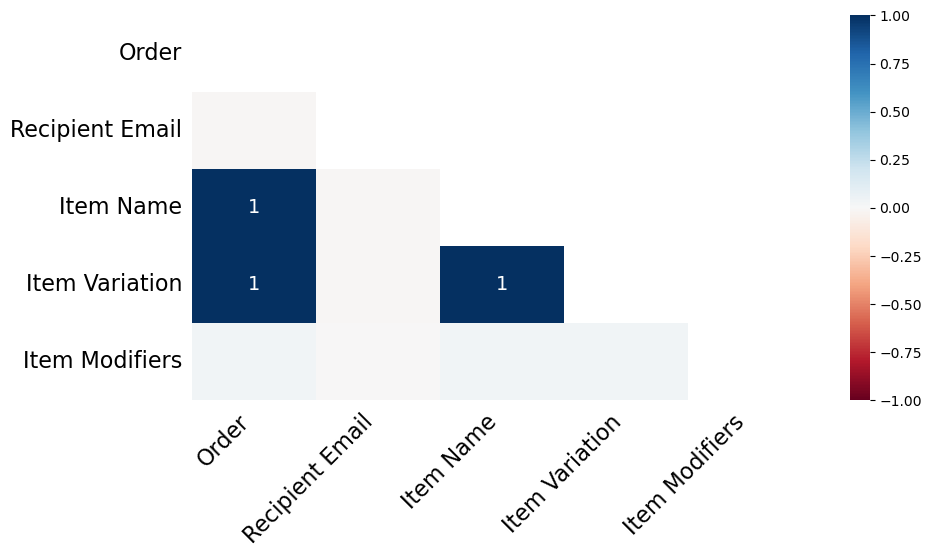

In [29]:
# Visualize missingness correlation

msno.heatmap(orders_processed_df, figsize=(10,5))

plt.show()

The perfectly correlated features come from the single row which had all of those missing. Otherwise, there are no significant missingness correlations.

In [36]:
orders_processed_df[orders_processed_df['Item Modifiers'].isna()]

,Order,Order Date,Order Subtotal,Order Tax Total,Order Total,Fulfillment Date,Fulfillment Type,Channels,Recipient Name,Recipient Email,Recipient Phone,Item Quantity,Item Name,Item Variation,Item Modifiers,Item Price,Item Options Total Price,Item Total Price
0,Uber Eats Delivery 8F819,2024-12-18,37.90,3.46,41.36,2024-12-18 13:58:00,Pickup,Postmates Delivery,8F819-Diana O.,NaN,+1 312-766-6835,1,CRISPY CHICKEN SANDWICH,Regular,NaN,16.46,16.46,18.02
2,Uber Eats Delivery 8F819,2024-12-18,37.90,3.46,41.36,2024-12-18 13:58:00,Pickup,Postmates Delivery,8F819-Diana O.,NaN,+1 312-766-6835,1,CREAMY BLUE CHEESE DIP,Regular,NaN,1.45,1.45,1.45
3,Uber Eats Delivery 8F819,2024-12-18,37.90,3.46,41.36,2024-12-18 13:58:00,Pickup,Postmates Delivery,8F819-Diana O.,NaN,+1 312-766-6835,1,ARTISAN MAC AND CHEESE,Side,NaN,7.25,7.25,7.94
4,Uber Eats Delivery 7751A,2024-12-17,113.09,10.74,123.83,2024-12-17 19:56:00,Pickup,Postmates Delivery,7751A-Lilit A.,NaN,+1 312-766-6835,3,BEEF SHORT RIB,Regular,NaN,33.95,33.95,111.52
5,Uber Eats Delivery 7751A,2024-12-17,113.09,10.74,123.83,2024-12-17 19:56:00,Pickup,Postmates Delivery,7751A-Lilit A.,NaN,+1 312-766-6835,1,ARTISAN MAC AND CHEESE,Side,NaN,7.25,7.25,7.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1386,DOORDASH,2024-01-05,31.97,2.28,34.25,2024-01-05 15:12:00,Pickup,DoorDash,Brandon K,point-of-sale-integration@doordash.com,8559731040,1,GET YOUR BABY BACK!,Half rack,NaN,23.99,23.99,25.70
1387,DOORDASH,2024-01-05,20.81,1.98,22.79,2024-01-05 13:49:00,Pickup,DoorDash,Timothy L,point-of-sale-integration@doordash.com,8559731040,1,MAC&CHEESE,Side,NaN,4.99,4.99,5.46
1388,DOORDASH,2024-01-05,20.81,1.98,22.79,2024-01-05 13:49:00,Pickup,DoorDash,Timothy L,point-of-sale-integration@doordash.com,8559731040,1,CRINKLE FRIES,"Side, Rosemary pepper",NaN,4.99,4.99,5.47
1390,DOORDASH,2024-01-04,35.37,2.60,37.97,2024-01-04 17:31:00,Pickup,DoorDash,Benjamin B,point-of-sale-integration@doordash.com,8559731040,1,GRILLED SWEET CORN,Regular,NaN,2.99,2.99,3.21


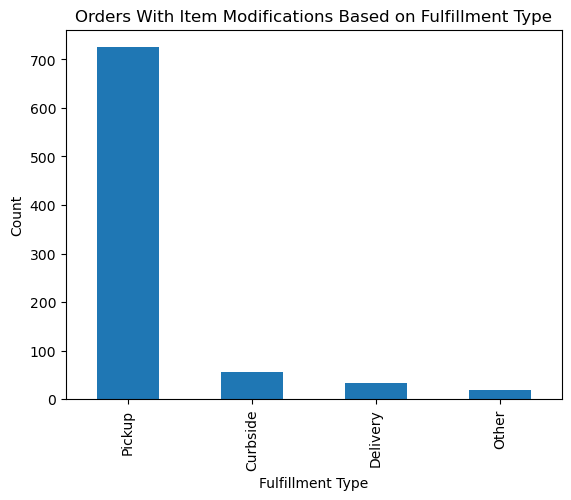

In [46]:
# Visualize relationship between item modifications and fulfillment type

orders_processed_df.groupby(by='Fulfillment Type')['Item Modifiers'].count().sort_values(ascending=False).plot(kind='bar')

plt.title('Orders With Item Modifications Based on Fulfillment Type')
plt.ylabel('Count')
plt.xlabel('Fulfillment Type')

plt.savefig(FIGURES_DIR / 'bar_fulfillment_type_item_modifiers_count.png', bbox_inches='tight')
plt.show()

### Recipient Email

This column is missing 23.8% of its values, so we'll investigate this as well. Most likely this is also a customer preference.

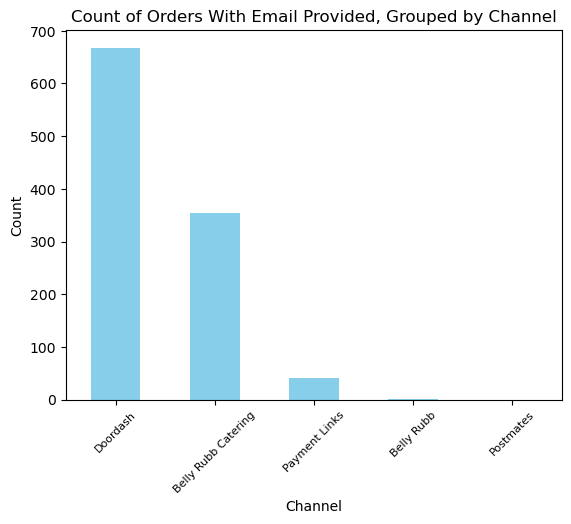

In [32]:
# Visualize count of whose emails were included based on Channel they ordered from

orders_processed_df.groupby(by='Channels')['Recipient Email'].count().sort_values(ascending=False).plot(kind='bar', color='skyblue')

x_tick_labels = ['Doordash', 'Belly Rubb Catering', 'Payment Links', 'Belly Rubb', 'Postmates']

plt.title('Count of Orders With Email Provided, Grouped by Channel')
plt.xlabel('Channel')
plt.ylabel('Count')
plt.xticks(range(len(x_tick_labels)), labels=x_tick_labels, rotation=45, fontsize=8)

plt.savefig(FIGURES_DIR / 'bar_email_channel_counts.png', bbox_inches='tight')
plt.show()

It looks like ordering through Postmates does not share customer emails. If emails are important for customer outreach and advertising, perhaps this can be changed upon.

## Outliers

There is a single row with Channels = Belly Rubb. We will investigate this.

In [47]:
orders_processed_df[orders_processed_df['Channels'] == 'Belly Rubb']

,Order,Order Date,Order Subtotal,Order Tax Total,Order Total,Fulfillment Date,Fulfillment Type,Channels,Recipient Name,Recipient Email,Recipient Phone,Item Quantity,Item Name,Item Variation,Item Modifiers,Item Price,Item Options Total Price,Item Total Price
1241,NaN,2024-03-07,450.0,42.75,512.75,2024-03-07 16:14:00,Other,Belly Rubb,Levon Safaryan,bidium@gmail.com,+1 818-822-5060,1,NaN,NaN,NaN,450.0,450.0,492.75


This is the same row that we discovered earlier with numerous columns with missing values. Perhaps more information can be collected from the client regarding this order, since dropping it would significantly affect our data.

## Correlations
Some columns are heavily correlated with each other according to the [profile report](/home/arsen/Documents/dsc_projects/belly_rubb_analysis/reports/profile-reports/orders-profile-report.html).

### Channels and Fulfillment Type

In [48]:
orders_processed_df.Channels

0                                      Postmates Delivery
1                                      Postmates Delivery
2                                      Postmates Delivery
3                                      Postmates Delivery
4                                      Postmates Delivery
                              ...                        
1394    BELLY RUBB | BBQ Catering | Barbecue To Go and...
1395    BELLY RUBB | BBQ Catering | Barbecue To Go and...
1396                                             DoorDash
1397                                             DoorDash
1398                                             DoorDash
Name: Channels, Length: 1399, dtype: object

# Items

In [3]:
items_df = pd.read_csv(data_path + 'items.csv')
items_df.head()

,Date,Time,Time Zone,Category,Item,Qty,Price Point Name,SKU,Modifiers Applied,Gross Sales,...,Location,Dining Option,Customer ID,Customer Name,Customer Reference ID,Unit,Count,Itemization Type,Fulfillment Note,Token
0,2023-12-31,17:48:40,Pacific Time (US & Canada),Mains,BELLY SLIDERS (Voided),1.0,6 sliders,NaN,NaN,$0.00,...,Belly Rubb,For Here,NaN,NaN,NaN,ea,1,Physical Good,NaN,9614A912-0D13-4E3A-85F5-E7115915F515
1,2023-12-31,17:48:40,Pacific Time (US & Canada),Mains,BELLY SLIDERS (Voided),1.0,4 sliders,NaN,NaN,$0.00,...,Belly Rubb,For Here,NaN,NaN,NaN,ea,1,Physical Good,NaN,066F4B7E-69FB-4554-88DA-99ECE8BEEB6A
2,2023-12-31,17:48:40,Pacific Time (US & Canada),Mains,GET YOUR BABY BACK! (Voided),2.0,Full Rack,NaN,NaN,$0.00,...,Belly Rubb,For Here,NaN,NaN,NaN,ea,2,Physical Good,NaN,4D4021CE-9753-4704-9A59-EC94859819B3
3,2023-12-31,17:48:40,Pacific Time (US & Canada),Sides,MAC&CHEESE (Voided),1.0,Full,NaN,NaN,$0.00,...,Belly Rubb,For Here,NaN,NaN,NaN,ea,1,Physical Good,NaN,UFAF57JBKMKJN6SZNS2MCH4M
4,2023-12-31,17:42:54,Pacific Time (US & Canada),Mains,BELLY SLIDERS,1.0,6 sliders,NaN,NaN,$22.15,...,Belly Rubb,For Here,Q170DHBMPCY9K1ZZ49P049BCER,Narek Ekmekjyan,NaN,ea,1,Physical Good,NaN,9614A912-0D13-4E3A-85F5-E7115915F515


In [14]:
orders_df = pd.read_csv(data_path + 'orders.csv')
orders_df.head()

,Order,Order Date,Currency,Order Subtotal,Order Shipping Price,Order Tax Total,Order Total,Order Refunded Amount,Fulfillment Date,Fulfillment Type,...,Recipient Region,Recipient Country,Item Quantity,Item Name,Item SKU,Item Variation,Item Modifiers,Item Price,Item Options Total Price,Item Total Price
0,Uber Eats Delivery 8F819,2024/12/18,USD,37.90,NaN,3.46,41.36,NaN,"12/18/2024, 1:58 PM",Pickup,...,NaN,NaN,1,CRISPY CHICKEN SANDWICH,NaN,Regular,NaN,16.46,16.46,18.02
1,Uber Eats Delivery 8F819,2024/12/18,USD,37.90,NaN,3.46,41.36,NaN,"12/18/2024, 1:58 PM",Pickup,...,NaN,NaN,1,LOADED FRIES,NaN,Regular,"1 x Signature BBQ Sauce Drizzle, 1 x Salt and ...",11.99,12.74,13.95
2,Uber Eats Delivery 8F819,2024/12/18,USD,37.90,NaN,3.46,41.36,NaN,"12/18/2024, 1:58 PM",Pickup,...,NaN,NaN,1,CREAMY BLUE CHEESE DIP,NaN,Regular,NaN,1.45,1.45,1.45
3,Uber Eats Delivery 8F819,2024/12/18,USD,37.90,NaN,3.46,41.36,NaN,"12/18/2024, 1:58 PM",Pickup,...,NaN,NaN,1,ARTISAN MAC AND CHEESE,NaN,Side,NaN,7.25,7.25,7.94
4,Uber Eats Delivery 7751A,2024/12/17,USD,113.09,NaN,10.74,123.83,NaN,"12/17/2024, 7:56 PM",Pickup,...,NaN,NaN,3,BEEF SHORT RIB,NaN,Regular,NaN,33.95,33.95,111.52


In [11]:
items_df['Customer Name'].value_counts()

Customer Name
Narek Ekmekjyan       8
Arus Keshishyan       4
Alissa Khachmanyan    4
Michael Keshishyan    3
Emily Samvalian       3
Name: count, dtype: int64

In [10]:
item_sales_df = pd.read_csv(data_path + 'item-sales-summary.csv')
item_sales_df.head()

,Item Name,Item Variation,SKU,Category,Items Sold,Gross Sales,Items Refunded,Refunds,Discounts & Comps,Net Sales,Tax,Unit,Units Sold,Units Refunded
0,BELLY SLIDERS,2 sliders,NaN,Uncategorized,1,$9.98,0,$0.00,$0.00,$9.98,$0.95,ea,1,0
1,BBQ dipping sauce,Regular,NaN,Condiments,3,$2.55,0,$0.00,$0.00,$2.55,$0.00,ea,3,0
2,SIGNATURE BBQ SAUCE,Regular,NaN,Condiments,2,$1.70,0,$0.00,$0.00,$1.70,$0.16,ea,2,0
3,BELLY SLIDERS,4 sliders,NaN,Mains,2,$30.84,0,$0.00,$0.00,$30.84,$2.69,ea,2,0
4,BELLY SLIDERS,6 sliders,NaN,Mains,1,$22.15,0,$0.00,$0.00,$22.15,$2.10,ea,1,0


In [4]:
customers_df = pd.read_csv(data_path + 'customer-directory.csv')
customers_df.head()

,Reference ID,First Name,Last Name,Email Address,Phone Number,Nickname,Company Name,Street Address 1,Street Address 2,City,...,Birthday,Memo,Square Customer ID,Creation Source,First Visit,Last Visit,Transaction Count,Total Spend,Email Subscription Status,Instant Profile
0,NaN,Ahlennah,Belton,eowyn797@gmail.com,'+18056996797,NaN,NaN,260 West Elmwood Avenue,Apt K,Burbank,...,NaN,NaN,RN17897VKN317B63F7WDRD0YFC,Merge,2024-04-24,2024-04-24,1,$56.69,unsubscribed,No
1,NaN,Alan L,Kaplan,manowa72@gmail.com,'+18186323824,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,J4ZV8PCYETVR99SG3380RJ5HKG,Instant Profile (via Payment),2024-11-16,2024-11-16,1,$28.97,unknown,Yes
2,NaN,Alejandra,Mejia,aledrm84@gmail.com,'+13235121733,NaN,NaN,5633 Colfax Avenue,Leasing office,Los Angeles,...,NaN,NaN,BRET0KG4Q127HFWN9MP5HQR820,Merge,2024-05-31,2024-05-31,1,$30.98,unknown,No
3,NaN,Alex,NaN,NaN,'+16266164211,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,MEKXVSXHDBBCKZBQ9CX8MB26ZW,Directory,2024-03-30,2024-03-30,1,NaN,NaN,No
4,NaN,Alexander,Diaz,alex.anthony.diaz@gmail.com,'+16266164211,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,JCJ1X244D95FZ8JYTX0VZEKCH8,Merge,2024-03-15,2024-09-17,14,$448.89,unknown,No
